In [16]:
import sys
sys.path.insert(0, '../Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io
from pysr import PySRRegressor

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [3]:
Nt=1000
P=np.zeros(Nt)
T=np.zeros(Nt)
k_t=3
r=1
dt=0.01

P[0]=0.2 #Initial conditions
T[0]=0
for i in range(1,Nt):
    P[i]=P[i-1]+ P[i-1]*r*(1-P[i-1]/k_t)*dt
    T[i]=T[i-1]+dt

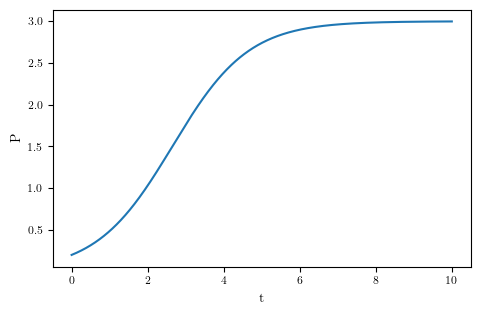

In [4]:
plt.plot(T,P)
plt.xlabel('t')
plt.ylabel('P')
plt.show()

In [5]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’



# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def net(t, w, b):
    p = DNN(t, w, b)
    return p


#@tf.function(jit_compile=True)
@tf.function()
def net_f(t, W_p, b_p, W_phi, b_phi, r):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([t])
        p=net(t, W_p, b_p)
        phi=net(p, W_phi, b_phi)
    p_t = tape1.gradient(p, t) 
    f = p_t - r*p - phi
    return f


#@tf.function()
@tf.function()
def train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, u_train_tf, X_f_train_tf, u_star_tf, opt, r):
    t_u = X_u_train_tf
    t_f = X_f_train_tf
    U_star = u_star_tf

    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W_p, b_p, W_phi, b_phi, k])
        u_nn = net(t_u, W_p, b_p) 
        phi_nn = net(U_star, W_phi, b_phi) 
        f_nn = net_f(t_f, W_p, b_p, W_phi, b_phi, r)
        loss_u = tf.reduce_mean(tf.square(u_nn - u_train_tf))
        loss_f = tf.reduce_mean(tf.square(f_nn)) 
        loss_phi = tf.reduce_mean(tf.square(phi_nn + r*U_star**2/k_t))

        loss =  loss_u + loss_f
    grads_p = tape.gradient(loss, train_vars(W_p, b_p))
    grads_phi = tape.gradient(loss, train_vars(W_phi, b_phi))

    opt.apply_gradients(zip(grads_p, train_vars(W_p, b_p)))
    opt.apply_gradients(zip(grads_phi, train_vars(W_phi, b_phi)))
   
    return loss, loss_u, loss_f, loss_phi




# N_u = 100 # Number of Initial and Boundary data points
N_f = 100 # Number of residual point
N_d = 100 #Number of data

layers = [1, 50, 50, 1]

L = len(layers)
W_p = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_p = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]
k = [tf.Variable(tf.ones([1,1]), dtype=tf.float32)]
W_phi = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b_phi = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]

In [6]:
u_star = P.reshape([-1, 1])
X_star = T.reshape([-1, 1])

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)  

# Initial Condition
xx1 = T[0]
uu1 = P[0]

# Additional data
idx = np.random.choice(P.shape[0], N_d, replace=False)
xxd = T[idx]
uud = P[idx]

X_u_train = np.concatenate(([xx1],xxd)).reshape([-1,1])
u_train = np.concatenate(([uu1],uud)).reshape([-1,1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
u_star_tf = tf.convert_to_tensor(u_star, dtype=tf.float32)

In [7]:
lr = 1e-3
Nmax = 10**5
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
loss_unk=[]
while n <= Nmax:
    loss_, loss_u, loss_f, loss_phi = train_step(W_p, b_p, W_phi, b_phi, X_u_train_tf, u_train_tf, X_f_train_tf,u_star_tf, optimizer, r)
    loss.append(loss_)
    loss_unk.append(loss_phi)
    if n % 10 == 0:
        print(f"Iteration is: {n}")
        print(f"Total loss is: {loss_}")

        print(f"Data loss is: {loss_u}")
        print(f"Physicial loss is: {loss_f}")
        print(f"Function unknown loss is: {loss_phi}")

    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0
Total loss is: 4.603166103363037
Data loss is: 4.484163761138916
Physicial loss is: 0.11900234967470169
Function unknown loss is: 6.334991931915283
Iteration is: 10
Total loss is: 0.9458584785461426
Data loss is: 0.28491050004959106
Physicial loss is: 0.6609479784965515
Function unknown loss is: 1.2596862316131592
Iteration is: 20
Total loss is: 0.6168955564498901
Data loss is: 0.09290798753499985
Physicial loss is: 0.5239875912666321
Function unknown loss is: 0.5211296677589417
Iteration is: 30
Total loss is: 0.25446319580078125
Data loss is: 0.05608412250876427
Physicial loss is: 0.19837908446788788
Function unknown loss is: 0.25457897782325745
Iteration is: 40
Total loss is: 0.2769642472267151
Data loss is: 0.11744000017642975
Physicial loss is: 0.15952426195144653
Function unknown loss is: 0.29408949613571167
Iteration is: 50
Total loss is: 0.20835906267166138
Data loss is: 0.04719668626785278
Physicial loss is: 0.1611623764038086
Function unknown loss is: 0.2006691

In [8]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net(x_star, w, b)
    return u_pred

## Evaluating total function
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W_p, b_p)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))                     
Error = 100* np.linalg.norm(u_star - u_pred) / np.linalg.norm(u_pred)

## Evaluating unknown function
U_star_tf = tf.convert_to_tensor(u_star, dtype=tf.float32) 
phi_pred = predict(U_star_tf, W_phi, b_phi)
phi_star=-r*u_star**2/k_t
error_phi = np.linalg.norm(phi_star-phi_pred,2)/np.linalg.norm(phi_pred,2)
print('Error phi: %e' %(error_phi)) 
Error_phi = 100* np.linalg.norm(phi_star - phi_pred) / np.linalg.norm(phi_pred)


Error u: 1.536305e-03
Error phi: 2.884417e-03


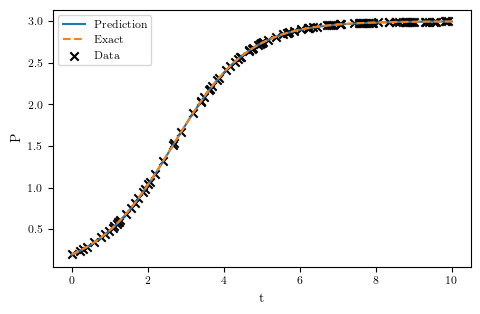

In [10]:
plt.plot(T, u_pred, label='Prediction')
plt.plot(T, P, linestyle='--', label='Exact')
plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('t')
plt.ylabel('P')
# plt.savefig('figures/P_phi.pdf')
plt.show()

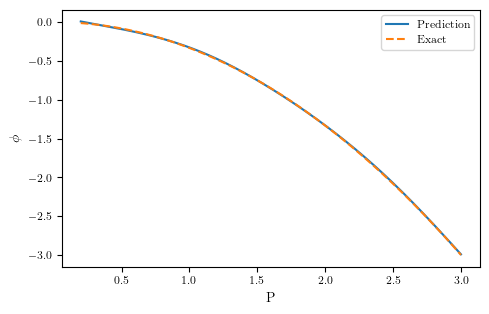

In [12]:
plt.plot(P, phi_pred, label='Prediction')
plt.plot(P, phi_star, linestyle='--', label='Exact')
# plt.scatter(X_u_train, u_train, marker='x', color='black',label='Data')
# plt.scatter(X_f_train, np.zeros(len(X_f_train)), marker='x')
plt.legend()
plt.xlabel('P')
plt.ylabel('$\phi$')
# plt.savefig('figures/phi.pdf')
plt.show()

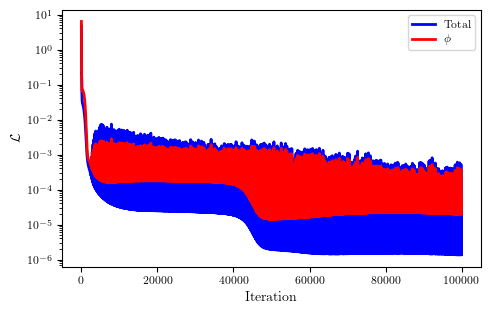

In [14]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
loss_phi_list = [loss_unk[i].numpy() for i in range(0,Nmax)]

plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Total')  
plt.semilogy(it, np.asarray(loss_phi_list), 'r-', linewidth = 2, label = '$\phi$')       

plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')  
plt.legend()  
# plt.savefig('figures/loss_phi.pdf')
plt.show()

 Hay que tener en cuenta que para k= 0.5 lo estaba ajustando a una curva lineal. Se pueden ver aun cosas de adaptative weight y LSB para mejorar la convergencia

## Symbolic Regression

In [17]:
# Create and train the PySR model
model = PySRRegressor(
    niterations=40,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    unary_operators=["exp", "inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2"
)


In [18]:
# Fit phi
model.fit(u_star, np.array(phi_pred))
print(model)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


Compiling Julia backend...


[ Info: Started!



Expressions evaluated per second: 1.750e+05
Head worker occupation: 37.5%
Progress: 383 / 600 total iterations (63.833%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           7.798e+00  1.594e+01  y = 0.64111
2           1.337e+00  1.764e+00  y = inv(-0.53236)
3           1.129e-01  2.471e+00  y = -0.91991 * x₀
4           1.539e-02  1.993e+00  y = exp(x₀) * -0.15334
5           1.950e-05  6.671e+00  y = (x₀ * -0.33264) * x₀
7           1.917e-05  8.546e-03  y = ((x₀ * x₀) * -0.33278) + 0.0011068
9           1.890e-05  7.049e-03  y = (-0.33197 * (x₀ * (x₀ + 0.0088988))) + 0.0029172
10          1.736e-05  8.497e-02  y = (0.0012263 * inv(x₀)) + ((-0.3327 * x₀) * x₀)
11          1.307e-05  2.839e-01  y = (0.00019546 * exp(inv(x₀))) + ((-0.3327 * x₀) * x₀)
13          1.264e-05  1.662e-02  y = (0.0012263 * (exp(inv(x₀)) * 0.12493)) + ((-0.3327 * x₀) *...
                      

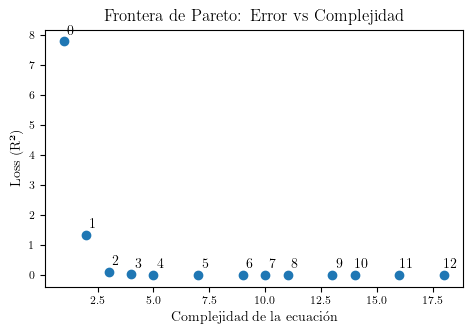

In [19]:
# Extraer las métricas de las ecuaciones
equations_df = model.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

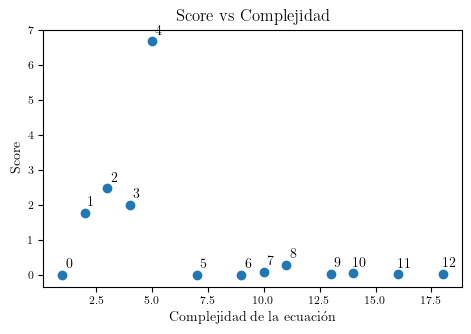

In [20]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


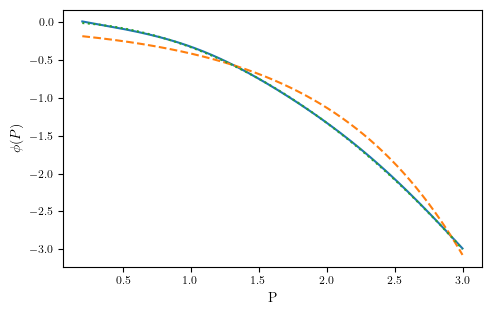

In [21]:
symb1=model.predict(u_star,3)
plt.plot(u_star, phi_pred, label='PINN prediction')
plt.plot(u_star, symb1, linestyle='--', label='Symbolic regresion')
plt.plot(u_star, phi_star, linestyle=':', label='Exact')

plt.xlabel('P')
plt.ylabel('$\phi (P)$')
plt.show()



In [22]:
model.sympy(3)

exp(x0)*(-0.15333779)

In [23]:
model.fit(u_pred, np.array(phi_pred))
print(model)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:1989: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 2.180e+05
Head worker occupation: 40.5%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 459 / 600 total iterations (76.500%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           2.237e+00  1.594e+01  y = -0.95166
2           1.336e+00  5.155e-01  y = inv(-0.52858)
3           1.115e-01  2.484e+00  y = -0.92098 * x₀
4           1.567e-02  1.962e+00  y = -0.15366 * exp(x₀)
5           2.632e-05  6.389e+00  y = -0.33317 * (x₀ * x₀)
7           2.304e-05  6.642e-02  y = (x₀ * (x₀ + 0.015155)) * -0.3314
9           2.167e-05  3.081e-02  y = (((x₀ * -0.32986) + -0.011093) * x₀) + 0.004774
12          1.682e-05  8.445e-02  y = (((-0.33201 * x₀) * x₀) + (0.004452 * inv(x₀))) + -0.01076...
                                  5
14          1.682e-05  8.941e-08  y = (i

In [24]:
# Fit dP/dt
# Create and train the PySR model
model = PySRRegressor(
    niterations=50,
    binary_operators=["+", "*"],
    # unary_operators=["cos", "exp", "sin", "inv(x) = 1/x"],
    unary_operators=[ "exp",  "inv(x) = 1/x"],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    elementwise_loss="loss(prediction, target) = (prediction - target)^2"
)

model.fit(X_star, np.array(u_pred))
print(model)

c:\Users\julia\anaconda3\envs\pinns\lib\site-packages\pysr\sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.980e+05
Head worker occupation: 46.7%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 407 / 750 total iterations (54.267%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           1.208e+01  1.594e+01  y = x₀
2           9.435e-01  2.549e+00  y = exp(0.78018)
3           2.649e-01  1.270e+00  y = 0.40424 * x₀
5           1.593e-01  2.544e-01  y = 0.64955 + (0.30678 * x₀)
6           5.526e-02  1.058e+00  y = exp(x₀ * -0.12388) * x₀
7           1.833e-02  1.103e+00  y = ((x₀ * -0.044468) + 0.7376) * x₀
9           1.435e-02  1.224e-01  y = (x₀ * (0.80837 + (x₀ * -0.049916))) + -0.17583
10          1.384e-02  3.611e-02  y = (x₀ * ((x₀ * -0.051088) + exp(-0.20187))) + -0.19957
11          1.384e-02  2.390e-05  y = ((0.87807 + (-0.051161 * (1.1765 + x₀))) * x₀) 

In [25]:
model.sympy(5)

x0*(0.7376004 + x0*(-0.044467866))

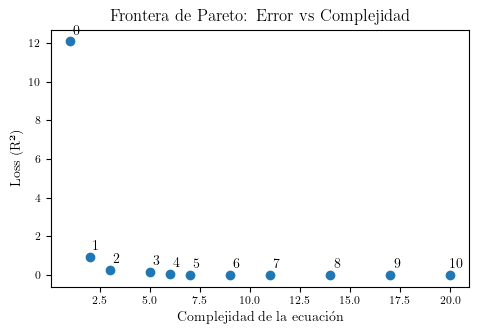

In [26]:
# Extraer las métricas de las ecuaciones
equations_df = model.equations_
# Obtener la complejidad y la puntuación (score) de cada ecuación
complejidades = equations_df['complexity']
errores = equations_df['loss']  # Por ejemplo, error MSE o cualquier métrica utilizada

# Crear el gráfico de dispersión
plt.scatter(complejidades, errores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, errores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')

# Añadir etiquetas y título
plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Loss (R²)')
plt.title('Frontera de Pareto: Error vs Complejidad')

# Mostrar gráfico
plt.show()

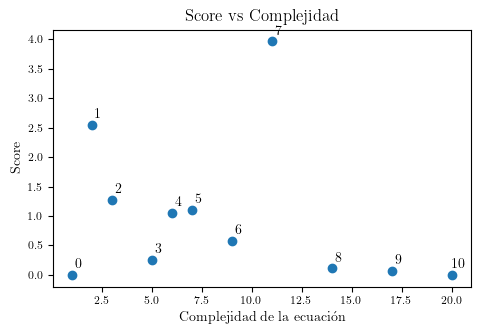

In [27]:
# Extraer complejidad y score
complejidades = equations_df['complexity']
scores = equations_df['score']

# Graficar score vs complejidad
plt.scatter(complejidades, scores)

# Añadir etiquetas de índice en cada punto
for i, (x, y) in enumerate(zip(complejidades, scores)):
    plt.annotate(i, (x, y), textcoords="offset points", xytext=(5,5), ha='center')


plt.xlabel('Complejidad de la ecuación')
plt.ylabel('Score')
plt.title('Score vs Complejidad')
plt.show()


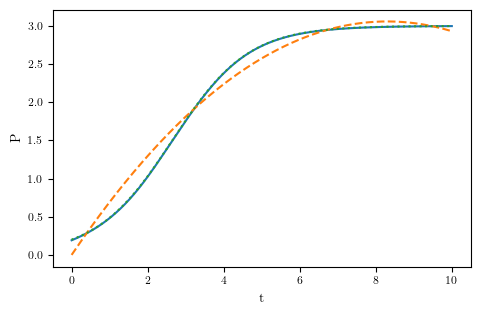

In [28]:
symb1=model.predict(X_star,5)
plt.plot(X_star, u_pred, label='PINN prediction')
plt.plot(X_star, symb1, linestyle='--', label='Symbolic regresion')
plt.plot(T, P, linestyle=':', label='Exact')

plt.xlabel('t')
plt.ylabel('P')
plt.show()

